## Mapping out lane lines
Once you have the thresholded, warped binary image, the next step is to map out the left and right lane lines. Plotting a histogram of where the binary activations occur across the image is one potential solution for this - we can use the two highest peaks from our histogram as a starting point for determining where the lane lines are.

In [1]:
# %load lane-utils.py
'''
Define functions for lane-finding project
'''

import glob
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pickle


# functions
def calibrate_camera(calibration_images):
    '''
    Compute the camera calibration matrix and distortion coefficients given calibration images
    '''
    # number of inside corners
    nx = 9
    ny = 6

    # Arrays to store object points and image points from all the images.
    objpoints = [] # 3d points in real world space for an undistorted image
    imgpoints = [] # 2d points in calibration image plane

    # define x,y,z points for an undistorted 3D image from 
    # top left: (0,0,0) to bottom right: (nx-1,ny-1,0)
    objp = np.zeros((nx*ny,3), np.float32)
    objp[:,:2] = np.mgrid[0:nx,0:ny].T.reshape(-1,2)


    # Step through the list and search for chessboard corners
    for i,fname in enumerate(calibration_images):
        img = cv2.imread(fname)

        # Convert to grayscale
        gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

        # Find the chessboard corners
        ret, corners = cv2.findChessboardCorners(gray, (nx, ny), None)

        #print(ret,corners)
        #print('---------------------\n')

        # if corners found, add object points, image points
        if ret == True:
            objpoints.append(objp)
            imgpoints.append(corners)
    
    # Read in an image and calibrate
    img = cv2.imread('./camera_cal/calibration4.jpg')
    img_size = (img.shape[1], img.shape[0])
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size,None,None)
    
    return objpoints, imgpoints, ret, mtx, dist, rvecs, tvecs

def color_gradient_thresh(img,s_thresh=(170, 255)):
    '''
    Apply color and gradient thresholding to generate a binary image where the lane lines are clearly visible
    '''
    # color threshold
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    H = hls[:,:,0]
    L = hls[:,:,1]
    S = hls[:,:,2]
    s_binary = np.zeros_like(S)
    s_binary[(S >= s_thresh[0]) & (S <= s_thresh[1])] = 1
    
    # gradient threshold (sobel magnitude and direction)
    gray = cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)
    kernel_size = 3 
    blur_gray = cv2.GaussianBlur(gray,(kernel_size, kernel_size),0)

    #sobelx
    sobel_kernel = 3
    sobelx = cv2.Sobel(blur_gray, cv2.CV_64F, 1, 0,ksize=sobel_kernel)
    abs_sobelx = np.absolute(sobelx)

    #sobely
    sobely = cv2.Sobel(blur_gray, cv2.CV_64F, 0, 1,ksize=sobel_kernel)
    abs_sobely = np.absolute(sobely)

    #sobel scaled and binary
    scaled_abs_sobelx = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    scaled_abs_sobely = np.uint8(255*abs_sobely/np.max(abs_sobely))
    gradx_binary = np.zeros_like(scaled_abs_sobelx)
    grady_binary = np.zeros_like(scaled_abs_sobely)
    sobel_thresh = (30,100)
    gradx_binary[(scaled_abs_sobelx >= sobel_thresh[0]) & (scaled_abs_sobelx <= sobel_thresh[1])] = 1
    grady_binary[(scaled_abs_sobely >= sobel_thresh[0]) & (scaled_abs_sobely <= sobel_thresh[1])] = 1
    
    # magnitude of sobelx and sobely
    absmag = abs_sobelx + abs_sobely
    scale_factor = np.max(absmag)/255 # Rescale to 8 bit (0-255)
    scaled_absmag = (cv2.GaussianBlur(absmag,(9, 9),0)/scale_factor).astype(np.uint8)
    mag_binary = np.zeros_like(scaled_absmag)
    mag_thresh = (30, 200)
    mag_binary[(scaled_absmag >= mag_thresh[0]) & (scaled_absmag <= mag_thresh[1])] = 1

    #direction of the gradient
    grad_dir_thresh=(0.7, 1.3)
    absgraddir = np.arctan2(np.absolute(sobely), np.absolute(sobelx))
    dir_binary =  np.zeros_like(absgraddir)
    dir_binary[(absgraddir >= grad_dir_thresh[0]) & (absgraddir <= grad_dir_thresh[1])] = 1

    #combining sobelx,sobely,magnitude,direction,and color thresholds
    combined_output = np.zeros_like(dir_binary)
    combined_output[((gradx_binary == 1) & (grady_binary == 1)) | \
                    ((mag_binary == 1) & (dir_binary == 1)) | \
                    (s_binary == 1)] = 1
    
    return combined_output

def undistort(img,mtx,dist):
    '''
    Undistort image using camera calibration matrices
    '''
    undistorted = cv2.undistort(img, mtx, dist, None, mtx)
    
    return undistorted

def perspective_transform(img):
    '''
    Get a top-down view of the road
    '''
    top_left = (560,480)
    top_right = (760,480)
    bottom_right = (1150,720)
    bottom_left = (260,720)
    
    img_size = (img.shape[1], img.shape[0])
    offset = 320
    region_of_interest = np.array([[top_left,top_right, bottom_right, bottom_left]], dtype=np.float32)
    # destination points chosen so that warped lane lines appear parallel
    destination = np.float32([[offset, 0], [img_size[0]-offset, 0], 
                                     [img_size[0]-offset, img_size[1]], 
                                     [offset, img_size[1]]])
#     tl = [320,0]
#     tr = [920,0]
#     br = [920,720]
#     bl = [320,720]
#     destination = np.float32([tl,tr,br,bl])

    # Given src and dst points, calculate the perspective transform matrix
    M = cv2.getPerspectiveTransform(region_of_interest,destination)
    # Warp the image using OpenCV warpPerspective()
    warped = cv2.warpPerspective(img, M, img_size)
    return warped, M

def hist(img):
    # Grab only the bottom half of the image
    # Lane lines are likely to be mostly vertical nearest to the car
    bottom_half = img[img.shape[0]//2:,:]

    # Sum across image pixels vertically
    # i.e. the highest areas of vertical lines should be larger values
    histogram = np.sum(bottom_half, axis=0)

    return bottom_half,histogram

def curve_fit():
    
    return None


In [2]:
# use chessboard images for calibration
calibration_images = glob.glob('./camera_cal/*.jpg')
objpoints, imgpoints, ret, mtx, dist, rvecs, tvecs = calibrate_camera(calibration_images)

(1280, 720)


(720, 1280)

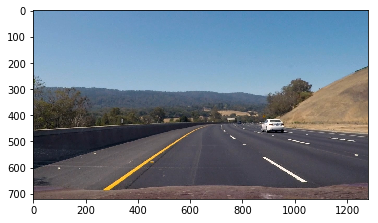

In [3]:
image = mpimg.imread('./test_images/test3.jpg')
img_size = (image.shape[1], image.shape[0])
plt.imshow(image)
print(img_size)
image.shape[:2]

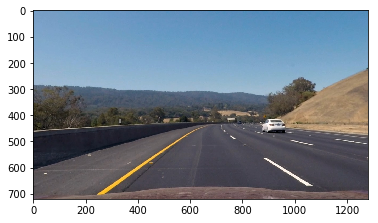

In [4]:
undistorted = undistort(image,mtx,dist)
#cv2.polylines(undistorted,np.array([[top_left,top_right, bottom_right, bottom_left]], dtype=np.int32),True,(205,92,92),5)

plt.imshow(undistorted)

In [5]:
binary_output = color_gradient_thresh(undistorted)

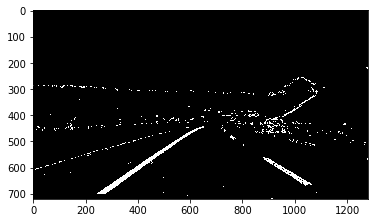

In [12]:
plt.imshow(binary_output/255,cmap='gray')

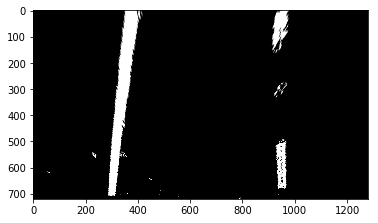

In [19]:
warped,M = perspective_transform(binary_output)
plt.imshow(warped/255,cmap='gray')
plt.savefig('./output_images/warped3.jpg')

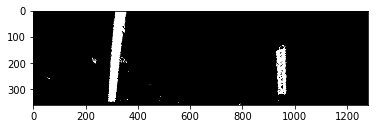

In [8]:

plt.imshow(warped[warped.shape[0]//2:],cmap='gray')

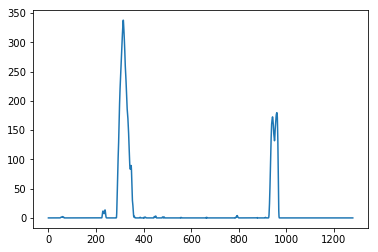

In [9]:
# Create histogram of image binary activations
bottom_half,histogram = hist(warped)

# Visualize the resulting histogram
plt.plot(histogram)

In [ ]:
# Load our image
#binary_warped = warped
binary_warped = mpimg.imread('./warped_example.jpg')
binary_warped.shape
print(binary_warped.shape)
def find_lane_pixels(binary_warped):
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    # Create an output image to draw on and visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]//2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # HYPERPARAMETERS
    # Choose the number of sliding windows
    nwindows = 10
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50

    # Set height of windows - based on nwindows above and image shape
    window_height = np.int(binary_warped.shape[0]//nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated later for each window in nwindows
    leftx_current = leftx_base
    rightx_current = rightx_base

    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),
        (win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),
        (win_xright_high,win_y_high),(0,255,0), 2) 
        
        # Identify the nonzero pixels in x and y within the window #
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices (previously was a list of lists of pixels)
    try:
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)
    except ValueError:
        # Avoids an error if the above is not implemented fully
        pass

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    return leftx, lefty, rightx, righty, out_img


def fit_polynomial(binary_warped):
    # Find our lane pixels first
    leftx, lefty, rightx, righty, out_img = find_lane_pixels(binary_warped)
    plt.imshow(out_img)
    # Fit a second order polynomial to each using `np.polyfit`
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)

    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    try:
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    except TypeError:
        # Avoids an error if `left` and `right_fit` are still none or incorrect
        print('The function failed to fit a line!')
        left_fitx = 1*ploty**2 + 1*ploty
        right_fitx = 1*ploty**2 + 1*ploty

    ## Visualization ##
    # Colors in the left and right lane regions
    out_img[lefty, leftx] = [255, 0, 0]
    out_img[righty, rightx] = [0, 0, 255]

    # Plots the left and right polynomials on the lane lines
    plt.plot(left_fitx, ploty, color='yellow')
    plt.plot(right_fitx, ploty, color='yellow')

    return out_img

# leftx, lefty, rightx, righty, out_img = find_lane_pixels(binary_warped)
# out_img[lefty, leftx] = [255, 0, 0]
# out_img[righty, rightx] = [0, 0, 255]
# plt.imshow(out_img,cmap='gray')
out_img = fit_polynomial(binary_warped)
plt.imshow(out_img)


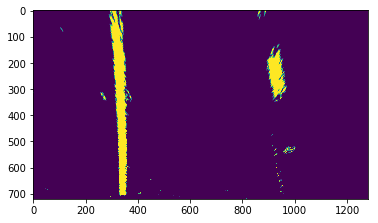

In [11]:
plt.imshow(warped)

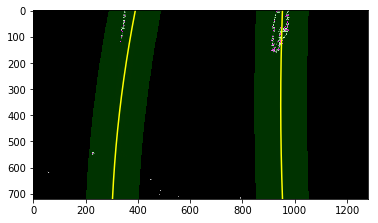

In [23]:
image2 = mpimg.imread('./test_images/test3.jpg')
undistorted2 = undistort(image2,mtx,dist)
binary_output2 = color_gradient_thresh(undistorted2)
warped2,M2 = perspective_transform(binary_output2)
# Load our image - this should be a new frame since last time!
binary_warped = warped2

# Polynomial fit values from the previous frame
# Make sure to grab the actual values from the previous step in your project!
left_fit = np.array([ 2.13935315e-04, -3.77507980e-01,  4.76902175e+02])
right_fit = np.array([4.17622148e-04, -4.93848953e-01,  1.11806170e+03])

def fit_poly(img_shape, leftx, lefty, rightx, righty):
     ### TO-DO: Fit a second order polynomial to each with np.polyfit() ###
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    # Generate x and y values for plotting
    ploty = np.linspace(0, img_shape[0]-1, img_shape[0])
    ### TO-DO: Calc both polynomials using ploty, left_fit and right_fit ###
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    return left_fitx, right_fitx, ploty

def search_around_poly(binary_warped):
    # HYPERPARAMETER
    # Choose the width of the margin around the previous polynomial to search
    # The quiz grader expects 100 here, but feel free to tune on your own!
    margin = 100

    # Grab activated pixels
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    ### TO-DO: Set the area of search based on activated x-values ###
    ### within the +/- margin of our polynomial function ###
    ### Hint: consider the window areas for the similarly named variables ###
    ### in the previous quiz, but change the windows to our new search area ###
    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + 
                    left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + 
                    left_fit[1]*nonzeroy + left_fit[2] + margin)))
    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + 
                    right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + 
                    right_fit[1]*nonzeroy + right_fit[2] + margin)))
    
    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    # Fit new polynomials
    left_fitx, right_fitx, ploty = fit_poly(binary_warped.shape, leftx, lefty, rightx, righty)
    
    ## Visualization ##
    # Create an image to draw on and an image to show the selection window
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    window_img = np.zeros_like(out_img)
    # Color in left and right line pixels
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

    # Generate a polygon to illustrate the search window area
    # And recast the x and y points into usable format for cv2.fillPoly()
    left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
    left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, 
                              ploty])))])
    left_line_pts = np.hstack((left_line_window1, left_line_window2))
    right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
    right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, 
                              ploty])))])
    right_line_pts = np.hstack((right_line_window1, right_line_window2))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
    cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
    result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
    
    # Plot the polynomial lines onto the image
    plt.plot(left_fitx, ploty, color='yellow')
    plt.plot(right_fitx, ploty, color='yellow')
    ## End visualization steps ##
    
    return result

# Run image through the pipeline
# Note that in your project, you'll also want to feed in the previous fits
result = search_around_poly(binary_warped)

# View your output
plt.imshow(result)

### Lane curvature

In [2]:
import numpy as np

def generate_data():
    '''
    Generates fake data to use for calculating lane curvature.
    In your own project, you'll ignore this function and instead
    feed in the output of your lane detection algorithm to
    the lane curvature calculation.
    '''
    # Set random seed number so results are consistent for grader
    # Comment this out if you'd like to see results on different random data!
    np.random.seed(0)
    # Generate some fake data to represent lane-line pixels
    ploty = np.linspace(0, 719, num=720)# to cover same y-range as image
    quadratic_coeff = 3e-4 # arbitrary quadratic coefficient
    # For each y position generate random x position within +/-50 pix
    # of the line base position in each case (x=200 for left, and x=900 for right)
    leftx = np.array([200 + (y**2)*quadratic_coeff + np.random.randint(-50, high=51) 
                                    for y in ploty])
    rightx = np.array([900 + (y**2)*quadratic_coeff + np.random.randint(-50, high=51) 
                                    for y in ploty])

    leftx = leftx[::-1]  # Reverse to match top-to-bottom in y
    rightx = rightx[::-1]  # Reverse to match top-to-bottom in y


    # Fit a second order polynomial to pixel positions in each fake lane line
    left_fit = np.polyfit(ploty, leftx, 2)
    right_fit = np.polyfit(ploty, rightx, 2)
    
    return ploty, left_fit, right_fit
    
def measure_curvature_pixels():
    '''
    Calculates the curvature of polynomial functions in pixels.
    '''
    # Start by generating our fake example data
    # Make sure to feed in your real data instead in your project!
    ploty, left_fit, right_fit = generate_data()
    
    # Define y-value where we want radius of curvature
    # We'll choose the maximum y-value, corresponding to the bottom of the image
    y_eval = np.max(ploty)
    
    # Calculation of R_curve (radius of curvature)
    left_curverad = ((1 + (2*left_fit[0]*y_eval + left_fit[1])**2)**1.5) / np.absolute(2*left_fit[0])
    right_curverad = ((1 + (2*right_fit[0]*y_eval + right_fit[1])**2)**1.5) / np.absolute(2*right_fit[0])
    
    return left_curverad, right_curverad


# Calculate the radius of curvature in pixels for both lane lines
left_curverad, right_curverad = measure_curvature_pixels()

print(left_curverad, right_curverad)
# Should see values of 1625.06 and 1976.30 here, if using
# the default `generate_data` function with given seed number

1625.06018317 1976.29673077


In [1]:
import numpy as np

def generate_data(ym_per_pix, xm_per_pix):
    '''
    Generates fake data to use for calculating lane curvature.
    In your own project, you'll ignore this function and instead
    feed in the output of your lane detection algorithm to
    the lane curvature calculation.
    '''
    # Set random seed number so results are consistent for grader
    # Comment this out if you'd like to see results on different random data!
    np.random.seed(0)
    # Generate some fake data to represent lane-line pixels
    ploty = np.linspace(0, 719, num=720)# to cover same y-range as image
    quadratic_coeff = 3e-4 # arbitrary quadratic coefficient
    # For each y position generate random x position within +/-50 pix
    # of the line base position in each case (x=200 for left, and x=900 for right)
    leftx = np.array([200 + (y**2)*quadratic_coeff + np.random.randint(-50, high=51) 
                                    for y in ploty])
    rightx = np.array([900 + (y**2)*quadratic_coeff + np.random.randint(-50, high=51) 
                                    for y in ploty])

    leftx = leftx[::-1]  # Reverse to match top-to-bottom in y
    rightx = rightx[::-1]  # Reverse to match top-to-bottom in y

    # Fit a second order polynomial to pixel positions in each fake lane line
    # Fit new polynomials to x,y in world space
    left_fit_cr = np.polyfit(ploty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(ploty*ym_per_pix, rightx*xm_per_pix, 2)
    
    return ploty, left_fit_cr, right_fit_cr
    
def measure_curvature_real():
    '''
    Calculates the curvature of polynomial functions in meters.
    '''
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    
    # Start by generating our fake example data
    # Make sure to feed in your real data instead in your project!
    ploty, left_fit_cr, right_fit_cr = generate_data(ym_per_pix, xm_per_pix)
    
    # Define y-value where we want radius of curvature
    # We'll choose the maximum y-value, corresponding to the bottom of the image
    y_eval = np.max(ploty)
    
    # Calculation of R_curve (radius of curvature)
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    
    return left_curverad, right_curverad


# Calculate the radius of curvature in meters for both lane lines
left_curverad, right_curverad = measure_curvature_real()

print(left_curverad, 'm', right_curverad, 'm')
# Should see values of 533.75 and 648.16 here, if using
# the default `generate_data` function with given seed number

533.752588921 m 648.157485143 m
